In [1]:
from google.cloud import bigquery
import pandas as pd
import os
import time
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

pd.options.display.max_columns = 50
pd.options.display.max_rows = 100
pd.options.display.min_rows = 20

In [2]:
os.environ['GOOGLE_APPLICATION+CREDENTIALS'] = '/Users/nrabbani/.config/gcloud/application_default_credentials.json'
os.environ['GCLOUD_PROJECT'] = 'mining-clinical-decisions'
%load_ext google.cloud.bigquery

client=bigquery.Client()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For mor

In [3]:
lradt = pd.read_pickle('data/lradt_acc_20210927.pkl')

In [4]:
# Get rid of labs ordered on the last day, due to issues with the timing right at the edge. There are multiple
# labs that have the order time and result time of 2021-10-31 00:00:00 and that is messing up the repetition 
print('Before pruning last day of labs:\t', len(lradt))
lradt = lradt.loc[lradt.result_time < lradt.result_time.max()]
print('After pruning last day of labs:\t\t', len(lradt))

Before pruning last day of labs:	 2386914
After pruning last day of labs:		 2374883


In [5]:
lradt['njr_labname'] = lradt['group_lab_name']

In [6]:
cbc =  ['CBC with Differential', 'CBC with Diff', 'CBC', 'CBC with Diff and Slide Review']
poct_urine = ['POCT Urine Dipstick (10)', 'POCT Urine Dipstick (9)']
poct_glucose = ['Glucose By Meter', 'Glucose PCX Meter']
lradt.loc[lradt.njr_labname.isin(cbc), 'njr_labname'] = 'CBC'
lradt.loc[lradt.njr_labname.isin(poct_urine), 'njr_labname'] = 'POCT Urine'
lradt.loc[lradt.njr_labname.isin(poct_glucose), 'njr_labname'] = 'POCT Glucose'

In [7]:
pd.DataFrame(lradt.njr_labname.value_counts()).head(30)

,njr_labname
CBC,478822
"Metabolic Panel, Comprehensive",240101
Chem 10,228085
Renal Function Panel,218235
POCT Urine,155812
POCT Glucose,70365
Urinalysis With Microscopic,62027
Manual Differential/Slide Review,48188
Red Blood Cells,45320
"Metabolic Panel, Basic",43813


In [8]:
labcounts = lradt.groupby(by='njr_labname').agg({'order_id_coded': 'nunique', 'pat_enc_csn_id_coded': 'nunique', 'anon_id': 'nunique'}).rename(columns={'order_id_coded': 'norders', 'pat_enc_csn_id_coded': 'nenc', 'anon_id': 'npat'}).sort_values('norders', ascending=False).head(30)

In [9]:
labcounts.head(30)

,norders,nenc,npat
njr_labname,,,
POCT Glucose,33095,2609,1595
CBC,27893,11559,7122
"Magnesium, Ser/Plas",22965,7122,3946
Chem 10,18468,5826,3874
Renal Function Panel,17612,4474,2570
POCT Urine,15663,1981,1259
"Metabolic Panel, Comprehensive",13760,6798,4120
"Tacrolimus Level, FK506",10009,2250,715
"Phosphorus, Ser/Plas",8599,4319,2785


In [10]:
labcounts['per_enc'] = labcounts.norders/labcounts.nenc
labcounts.sort_values(by='per_enc', ascending=False).head(30)

,norders,nenc,npat,per_enc
njr_labname,,,,
POCT Glucose,33095,2609,1595,12.684937
"ACT, Istat Kaolin Venous",2628,247,124,10.639676
POCT Urine,15663,1981,1259,7.906613
"Tacrolimus Level, FK506",10009,2250,715,4.448444
"Blood Gases, Arterial",2190,537,517,4.078212
Renal Function Panel,17612,4474,2570,3.936522
Red Blood Cells,6267,1707,1331,3.671353
"Triglyceride, Ser/Plas",4096,1123,739,3.647373
"Ammonia, Plasma",2804,800,528,3.505000


In [34]:
enclabcounts = lradt.groupby(by=['pat_enc_csn_id_coded', 'njr_labname']).agg({'order_id_coded': 'nunique'}).rename(columns={'order_id_coded': 'norders'}).sort_values('pat_enc_csn_id_coded', ascending=False)
enclabcounts.head(10)

norders
pat_enc_csn_id_coded njr_labname                           
324096930            Ammonia, Plasma                      1
324053387            Renal Function Panel                 1
                     POCT Glucose                         9
                     Magnesium, Ser/Plas                  1
324052544            Hepatitis Acute Panel                1
                     Alpha 1 Antitrypsin                  1
                     Alpha 1 Antitrypsin Phenotype        1
                     Amylase, Ser/Plas                    2
                     Bilirubin Direct, Ser/Plas           3
                     CBC                                  2

In [37]:
enclabcounts = enclabcounts.reset_index()

In [38]:
len(enclabcounts.pat_enc_csn_id_coded.unique())

19822

In [39]:
tempdf2 = enclabcounts.loc[enclabcounts.norders>1].groupby('njr_labname').agg({'pat_enc_csn_id_coded' : 'nunique', 'norders' : 'sum'}).sort_values('pat_enc_csn_id_coded', ascending=False)
tempdf2.head(30)

,pat_enc_csn_id_coded,norders
njr_labname,,
CBC,4943,21277
"Magnesium, Ser/Plas",3569,19412
Chem 10,3445,16087
Renal Function Panel,2815,15953
"Metabolic Panel, Comprehensive",2320,9282
POCT Urine,1853,15535
POCT Glucose,1781,32267
"Tacrolimus Level, FK506",1601,9360
"Phosphorus, Ser/Plas",1362,5642


In [15]:
tempdf2.sort_values('norders', ascending=False).rename(columns={'pat_enc_csn_id_coded': 'nenc', 'norders' : 'avg_norders'})

,nenc,avg_norders
njr_labname,,
POCT Glucose,1781,18.117350
"ACT, Istat Kaolin Venous",222,11.725225
Clozapine Level,2,11.000000
Lidocaine Level,69,10.869565
Specific Gravity,18,9.722222
Specific Gravity Refractometer POC,94,9.478723
Heparin Activity Level,85,9.305882
"ACT, ISTAT",5,9.000000
"Istat EC3, Venous",17,9.000000


In [46]:
tempdf2['perenc'] = tempdf2.norders / tempdf2.pat_enc_csn_id_coded
tempdf2 = tempdf2.loc[tempdf2.pat_enc_csn_id_coded > 1000].sort_values('perenc', ascending=False)
tempdf2.head(20)

,pat_enc_csn_id_coded,norders,perenc
njr_labname,,,
POCT Glucose,1781,32267,18.117350
POCT Urine,1853,15535,8.383702
"Tacrolimus Level, FK506",1601,9360,5.846346
Renal Function Panel,2815,15953,5.667140
"Magnesium, Ser/Plas",3569,19412,5.439059
Prothrombin Time,1192,6122,5.135906
Chem 10,3445,16087,4.669666
Gamma Glutamyl Trans,1073,4901,4.567568
CBC,4943,21277,4.304471


In [16]:
labnames = [
    'POCT Glucose',
    'Tacrolimus Level, FK506',
    'Renal Function Panel',
    'Magnesium, Ser/Plas',
    'Prothrombin Time',
    'Chem 10',
    'Gamma Glutamyl Trans',
    'CBC',
    'Phosphorus, Ser/Plas',
    'Metabolic Panel, Comprehensive'
]

In [17]:
lradt_orders = lradt.loc[lradt.njr_labname.isin(labnames)].groupby('order_id_coded').first()

In [18]:
len(lradt_orders)

166998

In [19]:
lradt_orders.head(2)

,uid,anon_id,pat_enc_csn_id_coded,component_id,order_type,proc_code,group_lab_name,lab_name,base_name,ord_num_value,reference_low,reference_high,reference_unit,result_in_range_yn,result_flag,order_time,result_time,effective_time_jittered,pat_class,department_id,pat_service,pat_lv_of_care,accomodation,from_base_class,to_base_class,in_event_type,out_event_type,event_id_coded,event_type,njr_labname
order_id_coded,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700773149,571947,JC588552,309013763,5397,Lab,LAB876,"Tacrolimus Level, FK506",Dosage (incl. Units of Measure),TACR3,9999999.0,3,20,ng/mL,Y,None,2014-04-13 08:06:00,2014-04-13 10:18:00,2014-04-12 23:59:00,Inpatient,10201108,Gastroenterology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,123309,Census,"Tacrolimus Level, FK506"
700773150,571959,JC588552,309013763,794,Lab,LAB19,Renal Function Panel,"Potassium, Ser/Plas",K,5.1,3.5,6.0,mmol/L,Y,High,2014-04-13 08:06:00,2014-04-13 09:58:00,2014-04-12 23:59:00,Inpatient,10201108,Gastroenterology,Acute Care,PEDS MED/SURG Level 3,Inpatient,Inpatient,Census,Census,123309,Census,Renal Function Panel


In [20]:
ordersdf = lradt_orders[['anon_id', 'pat_enc_csn_id_coded', 'njr_labname', 'order_time', 'result_time']].sort_values(['pat_enc_csn_id_coded', 'njr_labname', 'result_time', 'order_time'])
ordersdf.head(5)

,anon_id,pat_enc_csn_id_coded,njr_labname,order_time,result_time
order_id_coded,,,,,
701122666,JC608450,308903549,CBC,2014-05-25 21:05:00,2014-05-26 07:24:00
701239393,JC639827,308903923,CBC,2014-06-02 21:05:00,2014-06-03 08:06:00
701504059,JC984330,308904689,CBC,2014-06-30 21:05:00,2014-07-01 07:51:00
701287760,JC1142284,308905542,CBC,2014-05-02 13:35:00,2014-05-02 17:42:00
701390874,JC1142284,308905542,CBC,2014-05-03 21:05:00,2014-05-04 08:24:00


In [21]:
ordersdf.shift(1).head(5)

,anon_id,pat_enc_csn_id_coded,njr_labname,order_time,result_time
order_id_coded,,,,,
701122666,NaN,NaN,NaN,NaT,NaT
701239393,JC608450,308903549,CBC,2014-05-25 21:05:00,2014-05-26 07:24:00
701504059,JC639827,308903923,CBC,2014-06-02 21:05:00,2014-06-03 08:06:00
701287760,JC984330,308904689,CBC,2014-06-30 21:05:00,2014-07-01 07:51:00
701390874,JC1142284,308905542,CBC,2014-05-02 13:35:00,2014-05-02 17:42:00


In [22]:
ordersdf_shift = ordersdf.shift(1)
ordersdf['dif'] = pd.NaT
ordersdf['dif'] = ordersdf.order_time - ordersdf_shift.result_time

In [23]:
newlabidx = (ordersdf.njr_labname != ordersdf_shift.njr_labname) | (ordersdf.pat_enc_csn_id_coded != ordersdf_shift.pat_enc_csn_id_coded)

In [24]:
ordersdf.loc[newlabidx, 'dif'] = pd.NaT

In [25]:
ordersdf.head(30)

,anon_id,pat_enc_csn_id_coded,njr_labname,order_time,result_time,dif
order_id_coded,,,,,,
701122666,JC608450,308903549,CBC,2014-05-25 21:05:00,2014-05-26 07:24:00,NaT
701239393,JC639827,308903923,CBC,2014-06-02 21:05:00,2014-06-03 08:06:00,NaT
701504059,JC984330,308904689,CBC,2014-06-30 21:05:00,2014-07-01 07:51:00,NaT
701287760,JC1142284,308905542,CBC,2014-05-02 13:35:00,2014-05-02 17:42:00,NaT
701390874,JC1142284,308905542,CBC,2014-05-03 21:05:00,2014-05-04 08:24:00,1 days 03:23:00
701504067,JC1142284,308905542,CBC,2014-05-09 12:28:00,2014-05-09 13:37:00,5 days 04:04:00
701287759,JC1142284,308905542,Chem 10,2014-05-02 13:35:00,2014-05-02 18:04:00,NaT
701457513,JC1142284,308905542,Chem 10,2014-05-08 21:05:00,2014-05-09 05:49:00,6 days 03:01:00
701457516,JC1142284,308905542,Chem 10,2014-05-09 05:55:00,2014-05-09 07:26:00,0 days 00:06:00


In [26]:
repeat_orders = ordersdf.loc[ordersdf.dif.notnull()]
repeat_orders.head(10)

,anon_id,pat_enc_csn_id_coded,njr_labname,order_time,result_time,dif
order_id_coded,,,,,,
701390874,JC1142284,308905542,CBC,2014-05-03 21:05:00,2014-05-04 08:24:00,1 days 03:23:00
701504067,JC1142284,308905542,CBC,2014-05-09 12:28:00,2014-05-09 13:37:00,5 days 04:04:00
701457513,JC1142284,308905542,Chem 10,2014-05-08 21:05:00,2014-05-09 05:49:00,6 days 03:01:00
701457516,JC1142284,308905542,Chem 10,2014-05-09 05:55:00,2014-05-09 07:26:00,0 days 00:06:00
701504073,JC1142284,308905542,Chem 10,2014-05-09 21:05:00,2014-05-10 05:28:00,0 days 13:39:00
701504087,JC1142284,308905542,Chem 10,2014-05-10 21:05:00,2014-05-11 06:32:00,0 days 15:37:00
701504106,JC1142284,308905542,Chem 10,2014-05-11 21:05:00,2014-05-12 06:00:00,0 days 14:33:00
701580858,JC1142284,308905542,Chem 10,2014-05-12 21:05:00,2014-05-13 03:48:00,0 days 15:05:00
703408214,JC605249,308913369,CBC,2014-09-10 21:05:00,2014-09-11 07:45:00,41 days 10:06:00


In [27]:
time_quant = [pd.Timedelta('24H'), pd.Timedelta('3D'), pd.Timedelta('1W')]

In [28]:
labdtq_idx = ['<24h', '[24h, 3d)', '[3d, 7d)', '>=7d']
labdtq = pd.DataFrame(index=labdtq_idx)
for lab in labnames:
    print('Lab: ', lab)
    dtimes = repeat_orders.loc[repeat_orders.njr_labname==lab].dif
    p_enc = repeat_orders.loc[repeat_orders.njr_labname==lab, 'pat_enc_csn_id_coded'].nunique()
    dtq = []
    dtq.append(sum(dtimes < pd.Timedelta('24H')))
    dtq.append(sum( (dtimes < pd.Timedelta('3D')) & (dtimes >= pd.Timedelta('24H')) ))
    dtq.append(sum( (dtimes < pd.Timedelta('7D')) & (dtimes >= pd.Timedelta('3D')) ))
    dtq.append(sum((dtimes >= pd.Timedelta('7D')) ))
    dtq
    print('[0, 24h):\t', dtq[0])
    print('[24h, 3d)]:\t', dtq[1])
    print('[3d, 7d)]:\t', dtq[2])
    print('[7d, inf)]:\t', dtq[3])
    labdtq[lab] = np.cumsum(dtq)/p_enc*1000

Lab:  POCT Glucose
[0, 24h):	 29717
[24h, 3d)]:	 436
[3d, 7d)]:	 171
[7d, inf)]:	 162
Lab:  Tacrolimus Level, FK506
[0, 24h):	 6559
[24h, 3d)]:	 947
[3d, 7d)]:	 201
[7d, inf)]:	 52
Lab:  Renal Function Panel
[0, 24h):	 10090
[24h, 3d)]:	 2014
[3d, 7d)]:	 816
[7d, inf)]:	 218
Lab:  Magnesium, Ser/Plas
[0, 24h):	 11307
[24h, 3d)]:	 2628
[3d, 7d)]:	 1397
[7d, inf)]:	 511
Lab:  Prothrombin Time
[0, 24h):	 2641
[24h, 3d)]:	 1396
[3d, 7d)]:	 612
[7d, inf)]:	 281
Lab:  Chem 10
[0, 24h):	 7816
[24h, 3d)]:	 3475
[3d, 7d)]:	 998
[7d, inf)]:	 353
Lab:  Gamma Glutamyl Trans
[0, 24h):	 2423
[24h, 3d)]:	 652
[3d, 7d)]:	 605
[7d, inf)]:	 148
Lab:  CBC
[0, 24h):	 8824
[24h, 3d)]:	 4090
[3d, 7d)]:	 2458
[7d, inf)]:	 962
Lab:  Phosphorus, Ser/Plas
[0, 24h):	 2324
[24h, 3d)]:	 683
[3d, 7d)]:	 922
[7d, inf)]:	 351
Lab:  Metabolic Panel, Comprehensive
[0, 24h):	 3898
[24h, 3d)]:	 1214
[3d, 7d)]:	 1300
[7d, inf)]:	 550


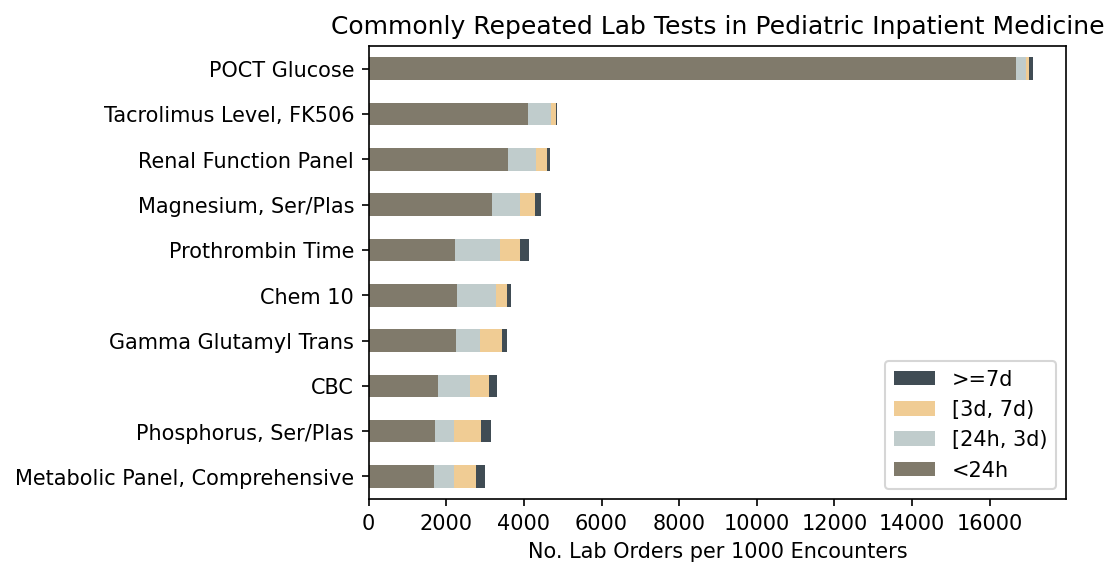

In [29]:
ax1 = labdtq.iloc[3].plot.barh(color='#404c54');
labdtq.iloc[2].plot.barh(ax=ax1, color='#f0cc94');
labdtq.iloc[1].plot.barh(ax=ax1, color='#c0cccc');
labdtq.iloc[0].plot.barh(ax=ax1, color='#807A6B');
ax1.legend();
ax1.invert_yaxis();
ax1.set_title('Commonly Repeated Lab Tests in Pediatric Inpatient Medicine');
ax1.set_xlabel('No. Lab Orders per 1000 Encounters');